In [1]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os
import datetime
try:
    os.chdir(r'/Users/joan/code/python/jokes-app/src/api')
    path_to_env = "/Users/joan/code/python/jokes-app/config/env-api.env"
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app/src/api')
    path_to_env = "/home/repos/joke-app/config/env-api.env"

In [2]:
import dotenv
dotenv.load_dotenv(dotenv_path=path_to_env)
from src.config import HOST as DB_HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import src.db.core as db

### Get connection to Postgres DB

In [5]:
conn = db.connect(host=DB_HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

# USERS

### Get Number of subscribed users and unsubscribed users

In [6]:
df = db.execute_read(conn, "select * from users_mail")

In [7]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

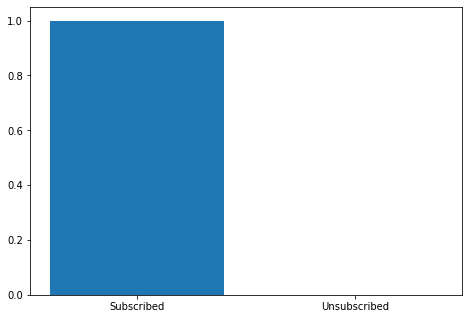

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [9]:
df_mean_user = db.execute_read(conn, """
select 
	split_part(um.email, '@', 1) as user, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [10]:
df_mean_user.head(20)

,user,avg,count
0,watxaut,7.065217,46


## TOP 5 Most Haters (min 5 reviews)

In [11]:
df_mean_user_min_count = df_mean_user[df_mean_user["count"] >= 5]
df_mean_user_hater = df_mean_user_min_count.sort_values(by=['avg', 'count'])
df_mean_user_hater.head(5)

,user,avg,count
0,watxaut,7.065217,46


## TOP 5 Supporters (min 5 reviews)

In [12]:
df_mean_user_supporter = df_mean_user_min_count.sort_values(by=['avg', 'count'], ascending=False)
df_mean_user_supporter.head()

,user,avg,count
0,watxaut,7.065217,46


## TOP JOKE SENDERS

In [13]:
sql = """
select 
    split_part(author_email, '@', 1) as user, count(*) as jokes_sent 
from 
    public.jokes_to_send 
where 
    author is not null and
    author_email is not null 
group by author_email 
order by jokes_sent desc
"""
df_marc_senders = db.execute_read(conn, sql)
df_marc_senders.head(5)

,user,jokes_sent


# USERS

## AVG joke rating per user

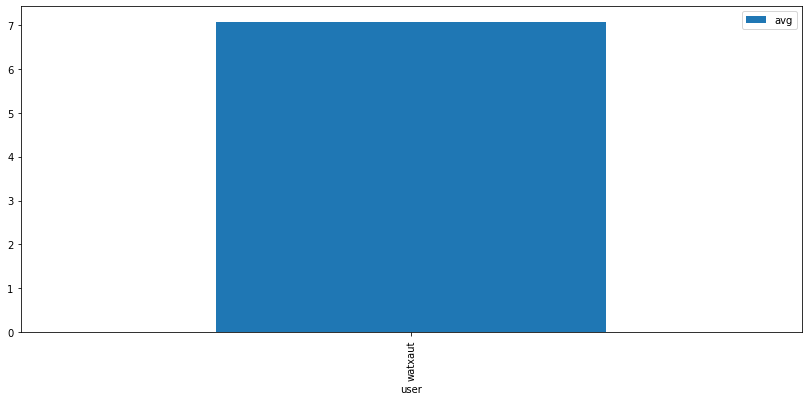

In [14]:
df_mean_user.sort_values(by=['avg'], ascending=False).plot.bar(x="user", y="avg", figsize=(14, 6))

### Rating Statistics

In [15]:
sql = """
select 
	sj.joke_id, r.rating, date(sj.created_at) as day, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail' and sj.sent_from = 'mail'
order by sj.created_at asc
"""
df_ratings = db.execute_read(conn, sql)
df_sent_mails = db.execute_read(conn, "select joke_id, date(created_at) as day from sent_jokes where sent_from = 'mail'")

#### Get last 10 ratings

In [16]:
df_ratings.tail(15)

,joke_id,rating,day,voted_at
447,194,6.0,2019-12-17,2019-12-17 08:11:36.640183
448,194,9.0,2019-12-17,2019-12-17 08:24:56.963834
449,194,6.0,2019-12-17,2019-12-17 10:24:29.763244
450,194,9.0,2019-12-17,2019-12-17 07:30:29.383083
451,194,2.0,2019-12-17,2019-12-17 15:42:12.142571
452,194,5.0,2019-12-17,2019-12-17 07:37:29.004778
453,194,7.0,2019-12-17,2019-12-17 08:32:29.724290
454,194,8.0,2019-12-17,2019-12-17 09:27:50.977865
455,194,10.0,2019-12-17,2019-12-17 09:27:51.716669
456,194,6.0,2019-12-17,2019-12-17 08:32:32.516783


## Get mean of ratings by joke and day

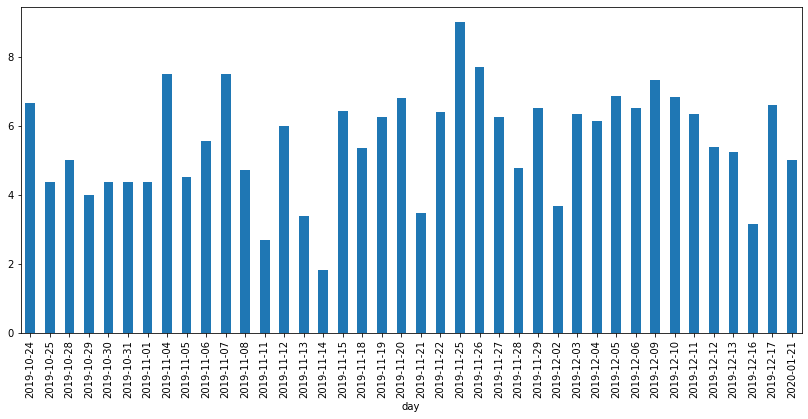

In [17]:
mean_ratings = df_ratings.groupby(["day"])["rating"].mean()
mean_ratings.tail(40).plot.bar(x="day", y="rating", figsize=(14, 6))

## Get Std Deviation of ratings by joke and day

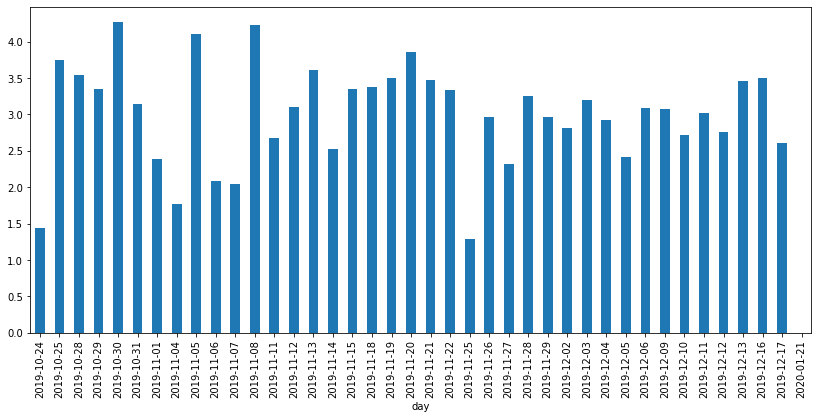

In [18]:
std_ratings = df_ratings.groupby(["day"])["rating"].std()
std_ratings.tail(40).plot.bar(x="day", y="std rating", figsize=(14, 6))

In [19]:
df_count_ratings = df_ratings.rename(columns={"rating": "count"}).groupby(["day"])["count"].count()
mean_ratings = pd.concat([mean_ratings, df_count_ratings], axis=1)
mean_ratings = mean_ratings[mean_ratings["count"] > 5]

std_ratings = pd.concat([std_ratings, df_count_ratings], axis=1)
std_ratings = std_ratings[std_ratings["count"] > 5]

In [20]:
# add again joke id to table
mean_ratings = mean_ratings.merge(df_sent_mails, on='day')
std_ratings = std_ratings.merge(df_sent_mails, on='day')

In [46]:
mean_ratings["day"] = mean_ratings["day"].astype("datetime64")
std_ratings["day"] = std_ratings["day"].astype("datetime64")
last_day = list(mean_ratings["day"].tail(1).to_dict().values())[0]

In [48]:
mean_ratings.head(5)

,day,rating,count,joke_id
19,2019-12-03,6.323529,17,340
20,2019-12-04,6.133333,15,339
21,2019-12-05,6.857143,14,255
22,2019-12-06,6.500000,14,147
23,2019-12-09,7.333333,18,135


In [41]:
mean_ratings = mean_ratings[mean_ratings["day"] > last_day - pd.Timedelta(days=15)]
std_ratings = std_ratings[std_ratings["day"] > last_day - pd.Timedelta(days=15)]

In [42]:
# get worst and best joke from mean - date
d_best = mean_ratings.sort_values(ascending=False, by='rating').head(1).to_dict(orient="index")
best_joke_id = list(d_best.values())[0]["joke_id"]
d_worst = mean_ratings.sort_values(ascending=False, by='rating').tail(1).to_dict(orient="index")
worst_joke_id = list(d_worst.values())[0]["joke_id"]

# get most controversial joke date
d_cont = std_ratings.sort_values(ascending=False, by='rating').head(1).to_dict(orient="index")
cont_joke_id = list(d_cont.values())[0]["joke_id"]

df_best = db.execute_read(conn, f"select * from jokes_to_send where id = {best_joke_id}")
df_worst = db.execute_read(conn, f"select * from jokes_to_send where id = {worst_joke_id}")
df_cont = db.execute_read(conn, f"select * from jokes_to_send where id = {cont_joke_id}")

## Best joke of last month

In [43]:
print(f"Joke:\n\n{df_best['joke'][0]}\n\nAuthor: {df_best['author'][0]}\nRating: {list(d_best.values())[0]['rating']}")

Joke:

+Mi novio siempre me lleva el desayuno a la cama.
-Es que eres invalida Maria
+Envidiosa de mierda...

Author: McDronals (pido perdon)
Rating: 7.333333333333333


## Worst joke of all time

In [44]:
print(f"Joke:\n\n{df_worst['joke'][0]}\n\nAuthor: {df_worst['author'][0]}\nRating: {round(list(d_worst.values())[0]['rating'], 2)}")

Joke:

¿Cuál es el pescado que no sabe pescar con caña?

El salmonete, porqué dice: 'Sal, monete!'

Author: Ingrid Falguera. Que la democracia decida la suerte del chiste.
Rating: 3.16


## Most controversial of all time

In [45]:
print(f"Joke:\n\n{df_cont['joke'][0]}\n\nAuthor: {df_cont['author'][0]}\nStd dev: {round(list(d_cont.values())[0]['rating'], 2)}")

Joke:

¿Cuál es el pescado que no sabe pescar con caña?

El salmonete, porqué dice: 'Sal, monete!'

Author: Ingrid Falguera. Que la democracia decida la suerte del chiste.
Std dev: 3.5
